In [1]:
 pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import numpy as np
np.random.seed(42)
import warnings;warnings.simplefilter('ignore')
%matplotlib inline
print("tensorflow version:",tf. __version__)

tensorflow version: 2.5.0


In [3]:
# Display 2D spectograms using Matplotlib
train_images = pd.read_csv("dataset/train/images.csv" , header = None)
train_labels = pd.read_csv("dataset/train/labels.csv" , header = None)

val_images = pd.read_csv("dataset/validation/images.csv" , header = None)
val_labels = pd.read_csv("dataset/validation/labels.csv" , header = None)

In [4]:
train_images.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,8152,8153,8154,8155,8156,8157,8158,8159,8160,8161,8162,8163,8164,8165,8166,8167,8168,8169,8170,8171,8172,8173,8174,8175,8176,8177,8178,8179,8180,8181,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,0.729412,0.725490,0.619608,0.674510,0.643137,0.705882,0.713726,0.658824,0.615686,0.690196,0.654902,0.525490,0.556863,0.541176,0.482353,0.588235,0.615686,0.600000,0.603922,0.627451,0.678431,0.658824,0.698039,0.576471,0.678431,0.686275,0.690196,0.705882,0.705882,0.643137,...,0.650980,0.666667,0.666667,0.709804,0.682353,0.682353,0.682353,0.658824,0.682353,0.643137,0.627451,0.623529,0.650980,0.721569,0.627451,0.635294,0.709804,0.690196,0.678431,0.647059,0.658824,0.682353,0.654902,0.694118,0.741176,0.678431,0.662745,0.729412,0.694118,0.647059,0.682353,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,0.678431,0.709804,0.713726,0.686275,0.717647,0.713726,0.694118,0.690196,0.721569,0.701961,0.698039,0.713726,0.705882,0.756863,0.756863,0.694118,0.650980,0.674510,0.752941,0.725490,0.725490,0.760784,0.678431,0.717647,0.725490,0.682353,0.709804,0.729412,0.721569,0.717647,...,0.686275,0.670588,0.713726,0.733333,0.725490,0.694118,0.694118,0.686275,0.674510,0.729412,0.721569,0.701961,0.682353,0.709804,0.756863,0.698039,0.729412,0.721569,0.674510,0.698039,0.725490,0.733333,0.666667,0.682353,0.701961,0.737255,0.745098,0.725490,0.698039,0.650980,0.721569,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,0.690196,0.670588,0.662745,0.666667,0.713726,0.701961,0.721569,0.713726,0.662745,0.698039,0.682353,0.639216,0.717647,0.658824,0.674510,0.639216,0.643137,0.635294,0.654902,0.682353,0.639216,0.733333,0.690196,0.658824,0.686275,0.658824,0.690196,0.698039,0.709804,0.650980,...,0.533333,0.572549,0.537255,0.549020,0.670588,0.690196,0.670588,0.643137,0.662745,0.713726,0.717647,0.721569,0.709804,0.674510,0.709804,0.686275,0.658824,0.694118,0.698039,0.694118,0.678431,0.678431,0.690196,0.662745,0.650980,0.650980,0.686275,0.631373,0.666667,0.701961,0.709804,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510
3,0.705882,0.674510,0.654902,0.678431,0.666667,0.662745,0.678431,0.662745,0.686275,0.686275,0.631373,0.650980,0.670588,0.737255,0.674510,0.615686,0.670588,0.705882,0.686275,0.678431,0.694118,0.647059,0.662745,0.682353,0.654902,0.721569,0.709804,0.631373,0.670588,0.674510,0.701961,0.725490,0.666667,0.647059,0.733333,0.682353,0.678431,0.603922,0.666667,0.713726,...,0.670588,0.705882,0.749020,0.662745,0.564706,0.623529,0.674510,0.709804,0.658824,0.631373,0.705882,0.670588,0.658824,0.690196,0.674510,0.658824,0.635294,0.682353,0.682353,0.639216,0.666667,0.654902,0.647059,0.670588,0.682353,0.639216,0.705882,0.729412,0.674510,0.666667,0.639216,0.662745,0.631373,0.643137,0.705882,0.662745,0.705882,0.666667,0.654902,0.631373
4,0.647059,0.729412,0.701961,0.674510,0.611765,0.698039,0.713726,0.662745,0.701961,0.674510,0.631373,0.709804,0.694118,0.698039,0.666667,0.690196,0.690196,0.682353,0.682353,0.647059,0.678431,0.658824,0.760784,0.729412,0.674510,0.694118,0.698039,0.713726,0.690196,0.698039,0.686275,0.705882,0.662745,0.670588,0.705882,0.682353,0.690196,0.733333,0.709804,0.701961,...,0.639216,0.690196,0.662745,0.658824,0.662745,0.698039,0.603922,0.690196,0.627451,0.627451,0.654902,0.725490,0.650980,0.717647,0.666667,0.709804,0.682353,0.674510,0.721569,0.741176,0.635294,0.615686,0.674510,0.690196,0.658824,0.694118,0.701961,0.670588,0.721569,0.780392,0.639216,0.670588,0.705882,0.674510,0.721569,0.694118,0.674510,0.705882,0.749020,0.729412


In [5]:
train_labels.head()

,0,1,2,3
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0


In [6]:
print("Training set shape:" , train_images.shape , train_labels.shape)
print("Validation set shape" , val_images.shape , val_labels.shape)

Training set shape: (3200, 8192) (3200, 4)
Validation set shape (800, 8192) (800, 4)


In [7]:
gray_train = train_images.values.reshape(3200 , 64 , 128)
x_train = np.repeat(gray_train[...,np.newaxis], 3, -1)
print(x_train.shape)
y_train = train_labels.values 


gray_val = val_images.values.reshape(800 , 64 , 128 )
x_val = np.repeat(gray_val[...,np.newaxis], 3, -1)
print(x_val.shape)
y_val = val_labels.values

(3200, 64, 128, 3)
(800, 64, 128, 3)


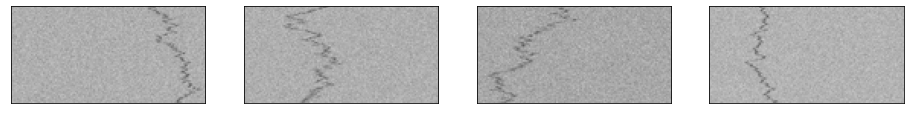

In [8]:
plt.figure(0 , figsize = (16 , 16))
for i in range(1 , 5):
    plt.subplot(1 , 4 , i)
    img = np.squeeze(x_train[np.random.randint(0 , x_train.shape[1])])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)

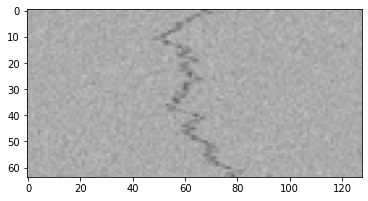

In [9]:
plt.imshow(np.squeeze(x_train[3]))

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_train = ImageDataGenerator(horizontal_flip=True)
data_train.fit(x_train)

data_val = ImageDataGenerator(horizontal_flip=True)
data_val.fit(x_val)

In [11]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.utils import plot_model

In [24]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, Model, Input

new_input = Input(shape=(64, 128, 3))
conv_base = VGG16(weights="imagenet",include_top=False,input_tensor=new_input, classes=4)
fine_tune =2;
for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
top_model = conv_base.output
top_model = Flatten(name="flatten")(top_model)
top_model = Dense(4096, activation='relu')(top_model)
top_model = Dense(1072, activation='relu')(top_model)
top_model = Dropout(0.2)(top_model)
output_layer = Dense(4, activation='softmax')(top_model)
vgg_model = Model(inputs=conv_base.input, outputs=output_layer)

#initial_learning_rate = 0.0001
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#                initial_learning_rate,
#                decay_steps = 5,
#                decay_rate = 0.96,
#                staircase = True)

optimizer = Adam(learning_rate = 0.00005)
vgg_model.compile(optimizer = optimizer , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
vgg_model.summary()


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 128, 3)]      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 128, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 128, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 32, 128)       0   

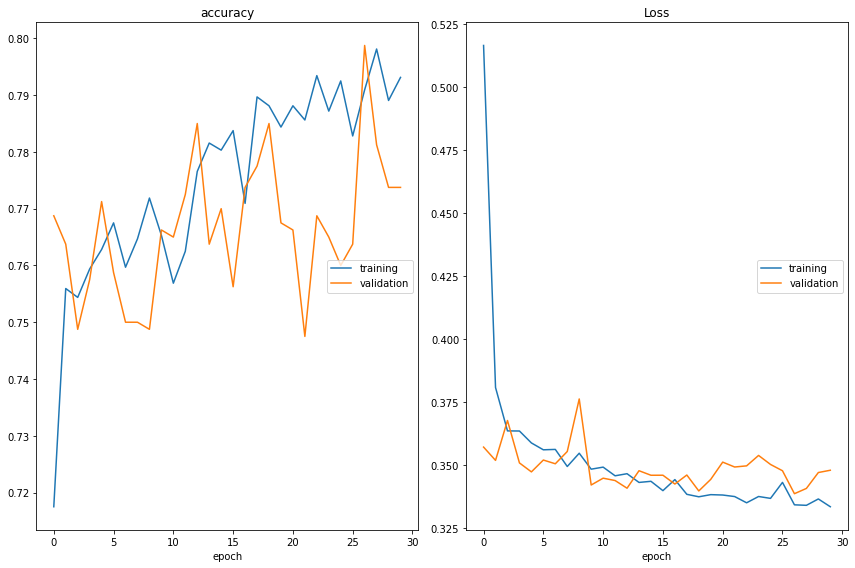

accuracy
	training         	 (min:    0.717, max:    0.798, cur:    0.793)
	validation       	 (min:    0.748, max:    0.799, cur:    0.774)
Loss
	training         	 (min:    0.334, max:    0.517, cur:    0.334)
	validation       	 (min:    0.339, max:    0.376, cur:    0.348)

Epoch 00030: val_loss did not improve from 0.33875


In [25]:
checkpoint = ModelCheckpoint('model_wght.h5' , monitor = 'val_loss' , save_best_only = True,
                            mode = 'min' , verbose = 1)
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')
callbacks = [PlotLossesCallback() , checkpoint, early_stop]  # reduce_lr

batch_size = 32

vgg_history = vgg_model.fit(
        data_train.flow(x_train , y_train , batch_size = batch_size , shuffle = True),
        steps_per_epoch = len(x_train) // batch_size,
        validation_data = data_val.flow(x_val , y_val , batch_size = batch_size , shuffle = True),
        validation_steps = len(x_val) // batch_size,
        epochs = 30,
        callbacks = callbacks
)

In [26]:

vgg_model.evaluate(x_val , y_val)


25/25 [==============================] - 1s 32ms/step - loss: 0.3436 - accuracy: 0.7738


[0.3436015844345093, 0.7737500071525574]

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns

vgg_model.load_weights('model_wght.h5')
y_true = np.argmax(y_val , 1)
y_pred = np.argmax(vgg_model.predict(x_val) , 1)
print(metrics.classification_report(y_true , y_pred))
print("Classification accuracy: %0.6f" % metrics.accuracy_score(y_true,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       0.60      0.53      0.56       200
           2       0.58      0.65      0.61       200
           3       1.00      1.00      1.00       200

    accuracy                           0.79       800
   macro avg       0.79      0.79      0.79       800
weighted avg       0.79      0.79      0.79       800

Classification accuracy: 0.793750


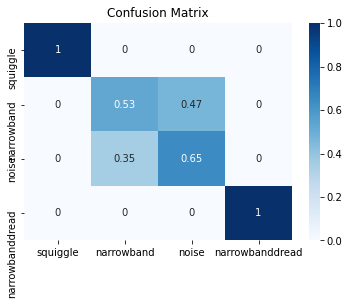

In [28]:
labels = ['squiggle','narrowband','noise','narrowbanddread']
ax= plt.subplot()
sns.heatmap(metrics.confusion_matrix(y_true,y_pred,normalize='true'),annot=True,ax=ax,cmap= plt.cm.Blues);

ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels);
ax.yaxis.set_ticklabels(labels);